## Node2vec

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import pickle

In [2]:
from sklearn.decomposition import PCA

In [3]:
import sys

sys.path.append("./node2vec/src/")

In [4]:
import utils.utils as u

In [5]:
import main as n2v
import node2vec as n2v_src
import networkx as nx

In [6]:
from importlib import reload
n2v = reload(n2v)
n2v_src = reload(n2v_src)

In [7]:
gr0 = np.load("../data/graphs/SlO_22.npy")#[:34,:34]
nd = pickle.load(open("../data/dicts/SlO_counts_22", 'rb'))
sp_to_n = pickle.load(open("../data/dicts/SlO_sp_to_n_22", 'rb'))

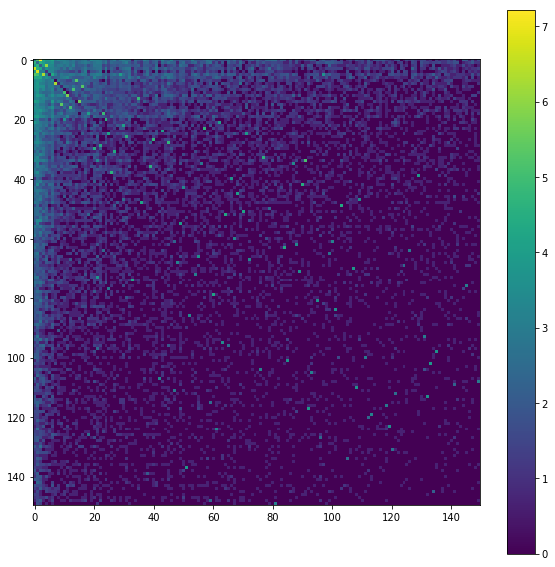

In [8]:
u.plot_gr(gr0[:150, :150], log = 1)

In [9]:
good_keys = []
for k in nd.keys():
    if nd[k] > 5:
        good_keys.append(k)

In [10]:
mask = np.zeros(gr0.shape[0]).astype(bool)
for k in good_keys:
    mask[sp_to_n[k]] = True

In [11]:
gr = gr0[mask][:, mask]

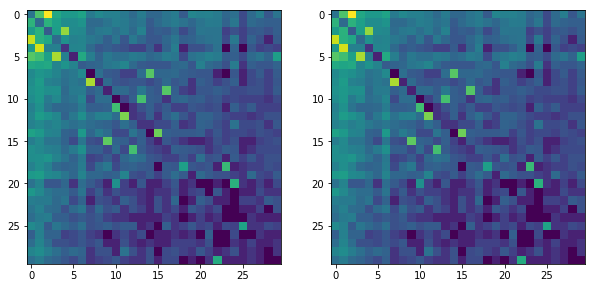

In [12]:
u.plot_grs(gr0[:30, :30], gr[:30, :30], log=1)

In [13]:
gr[(gr.sum(1) == 0)] = 1

In [14]:
gr.shape

(746, 746)

In [45]:
np.save("../data/graphs/SlO_22_cut_at_10", gr)

## SlO

In [17]:
gr_all = gr
gr = gr_all[:50,:50]

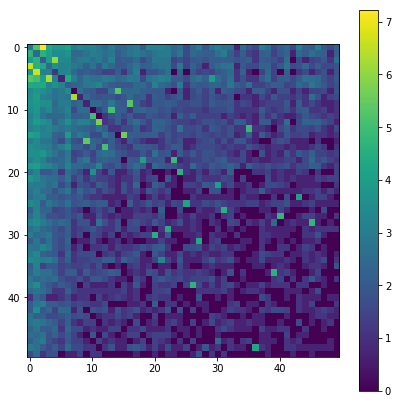

In [19]:
u.plot_gr(gr, log = 1, s = 7)

In [49]:
def plot_embs_space(emb, p_as_list, special_cases):
    plt.scatter(emb[:,0], emb[:, 1])

    plt.scatter(emb[p_as_list[0],0], emb[p_as_list[0], 1], c = 'r')
    plt.scatter(emb[1,0], emb[1, 1], marker = 'x', s= 200, c = 'r')


    plt.scatter(emb[p_as_list[3],0], emb[p_as_list[3], 1], c = 'g')



    plt.scatter(emb[p_as_list[1],0], emb[p_as_list[1], 1], c = 'y')
    plt.scatter(emb[4,0], emb[4, 1], marker = 'x', s= 200, c = 'y')


    plt.scatter(emb[p_as_list[2],0], emb[p_as_list[2], 1], c = 'black')

In [423]:
def random_walks(gr, walks_n, max_len):
    sums = gr.sum(1)
    mask = sums != 0
    gr_n = gr / sums.reshape(-1, 1)
      
    walks = []
    
    for i in range(walks_n * gr.shape[0]):
        #curr = np.random.randint(0, gr_n.shape[0])
        curr = i % gr.shape[0]
        walk = []
        stop = False
        while not stop:
            walk.append(curr)
            if gr[curr].sum() == 0 or len(walk) == max_len:
                stop = True
            else:
                curr = np.random.choice(np.arange(gr.shape[0]), 1, p = gr_n[curr])[0]
                max_tries = 0
                while curr in walk and max_tries < 20:
                    curr = np.random.choice(np.arange(gr.shape[0]), 1, p = gr_n[curr])[0]
                    max_tries += 1
        
        walks.append(walk)
    
    return walks

In [13]:
def gr_to_nxGr(graph):
    nxG = nx.DiGraph()
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            nxG.add_edge(i, j, weight = graph[i,j])
    return nxG

In [421]:
def gr_to_emb(graph, walks_n, l, emb_size = 20):
    spacers_num = graph.shape[0]
    
#     print("ngx")
#     nx_gr = gr_to_nxGr(graph)
#     G = n2v_src.Graph(nx_gr, 1, 0.5, 0.5)
#     G.preprocess_transition_probs()
#     print('walks')
#     walks = G.simulate_walks(walks_n, l)

    walks = random_walks(graph, walks_n, l)
    print('train')
    model = n2v.learn_embeddings(walks, emb_size, 3, 4, 200)
    
    print("PCA")
    E = np.zeros((spacers_num, emb_size))
    for i in range(spacers_num):
        E[i] = model.wv.word_vec(str(i))
    pca = PCA(n_components=emb_size)
    
    return pca.fit_transform(E), model, walks

In [422]:
emb, model, walks = gr_to_emb(gr, 100, 20)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


train
PCA


In [76]:
log_emb, log_model, walks = gr_to_emb(np.log(gr + 1), 100, 10)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


train
PCA


In [56]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [405]:
walks

[[0, 3, 6, 8, 16, 9, 10, 13, 14, 15, 7, 17, 12, 11, 22],
 [1, 9, 10, 13, 14, 15, 7, 11, 6, 8, 30, 27, 26, 28, 31],
 [2, 11, 0, 7, 16, 10, 13, 14, 15, 5, 17, 12, 4, 3, 6],
 [3, 6, 8, 16, 9, 10, 13, 14, 15, 1, 0, 21, 11, 4, 2],
 [4, 2, 5, 7, 11, 0, 3, 6, 8, 9, 14, 15, 17, 12, 16],
 [5, 7, 11, 10, 13, 14, 15, 17, 12, 16, 8, 9, 6, 3, 0],
 [6, 8, 9, 10, 13, 14, 15, 17, 12, 16, 0, 3, 1, 4, 2],
 [7, 11, 16, 9, 10, 13, 14, 15, 17, 12, 3, 6, 8, 4, 2],
 [8, 9, 10, 6, 4, 2, 5, 7, 11, 14, 15, 13, 17, 12, 16],
 [9, 10, 1, 20, 22, 11, 2, 5, 7, 16, 3, 6, 8, 13, 14],
 [10, 13, 14, 15, 17, 0, 3, 6, 8, 9, 12, 16, 11, 1, 2],
 [11, 0, 3, 6, 8, 9, 10, 13, 7, 14, 16, 20, 22, 15, 1],
 [12, 16, 8, 9, 10, 13, 14, 15, 17, 0, 3, 6, 1, 4, 2],
 [13, 14, 15, 17, 9, 10, 16, 3, 6, 8, 11, 0, 12, 28, 31],
 [14, 15, 6, 8, 9, 10, 13, 17, 12, 16, 11, 2, 5, 4, 1],
 [15, 17, 12, 16, 6, 8, 7, 11, 2, 5, 0, 3, 4, 1, 9],
 [16, 8, 9, 10, 13, 17, 12, 14, 15, 0, 7, 11, 2, 5, 1],
 [17, 12, 16, 0, 3, 6, 8, 9, 10, 13, 14, 15, 2, 5, 7

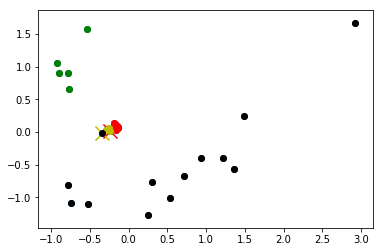

In [424]:
plot_embs_space(emb, population_as_list, None)

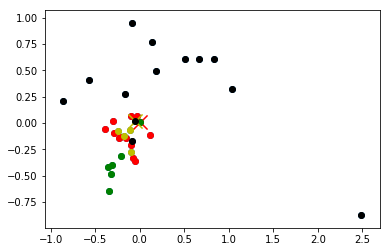

In [78]:
plot_embs_space(log_emb, population_as_list, None)

In [426]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [425]:
model.most_similar(positive='1')

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('11', 0.7298898696899414),
 ('4', 0.7139437794685364),
 ('3', 0.5548408627510071),
 ('16', 0.5481078624725342),
 ('15', 0.4785696566104889),
 ('18', 0.47004812955856323),
 ('8', 0.43234941363334656),
 ('2', 0.4194122850894928),
 ('32', 0.4171842932701111),
 ('9', 0.40366363525390625)]

### Inv walks

In [407]:
from nltk import ngrams

In [411]:
trigrams = {}

In [412]:
for w in walks:
    for x in  ngrams(w, 3):
        if x in trigrams:
            trigrams[x] += 1
        else:
            trigrams[x] = 1

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'ngrams' raised StopIteration
  


In [414]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [415]:
trigrams[(1, 20, 22)]

33

In [420]:
for i in range(35):
    for j in range(35):
        if (1,i,j) in trigrams:
            print((1,i,j), trigrams[(1,i,j)])

(1, 0, 2) 49
(1, 0, 3) 2309
(1, 0, 4) 73
(1, 0, 5) 30
(1, 0, 6) 58
(1, 0, 7) 86
(1, 0, 8) 30
(1, 0, 9) 36
(1, 0, 10) 53
(1, 0, 11) 83
(1, 0, 12) 53
(1, 0, 13) 52
(1, 0, 14) 39
(1, 0, 15) 11
(1, 0, 16) 25
(1, 0, 17) 27
(1, 0, 18) 3
(1, 0, 19) 3
(1, 0, 20) 2
(1, 0, 21) 6
(1, 0, 22) 1
(1, 0, 23) 3
(1, 0, 24) 1
(1, 0, 27) 1
(1, 0, 30) 1
(1, 0, 34) 1
(1, 2, 4) 2
(1, 2, 5) 83
(1, 2, 6) 1
(1, 2, 10) 1
(1, 2, 11) 1
(1, 2, 17) 1
(1, 2, 31) 1
(1, 3, 0) 3
(1, 3, 2) 1
(1, 3, 4) 2
(1, 3, 5) 1
(1, 3, 6) 62
(1, 3, 7) 3
(1, 3, 8) 1
(1, 3, 9) 1
(1, 3, 10) 2
(1, 3, 11) 4
(1, 3, 12) 1
(1, 3, 13) 1
(1, 3, 14) 2
(1, 3, 15) 1
(1, 4, 0) 1
(1, 4, 2) 92
(1, 4, 3) 1
(1, 4, 5) 1
(1, 4, 6) 1
(1, 4, 7) 5
(1, 4, 8) 1
(1, 4, 11) 4
(1, 4, 12) 2
(1, 4, 13) 1
(1, 4, 14) 3
(1, 4, 17) 1
(1, 4, 24) 1
(1, 5, 7) 35
(1, 5, 9) 1
(1, 5, 10) 1
(1, 5, 11) 2
(1, 5, 12) 1
(1, 5, 16) 1
(1, 6, 2) 2
(1, 6, 3) 1
(1, 6, 5) 3
(1, 6, 7) 4
(1, 6, 8) 57
(1, 6, 9) 2
(1, 6, 13) 3
(1, 6, 14) 2
(1, 6, 16) 2
(1, 7, 0) 2
(1, 7, 2) 3
(1, 7, 3) 1


## Model Edge pred

In [89]:
import h_module.hamiltonian_path as hp

In [91]:
c = {}
hp.next_edge(gr,c)

10

In [94]:
def get_weights(gr,chain):
    w = []
    for x, y in zip(chain, chain[1:]):
        w.append(gr[x][y])
    return w

In [108]:
def get_positive_edges(chain, weights, trsh):
    good_edges = []
    chains = []
    
    curr_chain = []
    for x,y,w in zip(chain, chain[1:], weights):
        if w >= trsh:
            good_edges.append((x, y))
            if len(curr_chain) == 0:
                curr_chain.append(x)
            curr_chain.append(y)
        else:
            chains.append(curr_chain)
            curr_chain = []
    if not curr_chain in chains:
        chains.append(curr_chain)
        
    return good_edges, chains

In [109]:
c[0]

[4, 2, 5, 7, 11, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34, 20, 22, 23, 21, 29, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16]

In [110]:
w = get_weights(gr, c[0].chain)

In [113]:
positive_edges, positive_chains = get_positive_edges(c[0].chain, w, 5)

In [384]:
def generate_negative_edge(positive_edges, positive_chains):
    edges = []
    
    for edge in positive_edges:
        edges.append(edge[::-1])
        
    for c in positive_chains:
        for i, v in enumerate(c):
            for j in range(0, i - 1):
                edges.append((v, c[j]))
                edges.append((c[j], v))

    return edges

In [385]:
negative_edges = generate_negative_edge(positive_edges, positive_chains)

In [388]:
(5,2) in negative_edges

True

In [287]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [389]:
def generate_dataset(emb, positive_edges, negative_edges):
    data = np.zeros((len(positive_edges) + len(negative_edges), emb.shape[1] * 2))
    y = np.zeros(data.shape[0])
    
    for i,edge in enumerate(positive_edges):
        data[i] = np.hstack((emb[edge[0]], emb[edge[1]]))
        y[i] = 1
    
    shift = len(positive_edges)
    for i,edge in enumerate(negative_edges):
        data[i + shift] = np.hstack((emb[edge[0]], emb[edge[1]]))
        y[i + shift] = 0
    
    return data, y
    

In [427]:
X, y = generate_dataset(emb, positive_edges, negative_edges)

In [428]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [429]:
lr = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(100, class_weight='balanced')

In [430]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [431]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [432]:
from tqdm import tqdm_notebook

In [433]:
def range_graph(gr, emb, model):
    scores = np.zeros_like(gr)
    
    for i in tqdm_notebook(range(gr.shape[0])):
        for j in range(gr.shape[1]):
            x = np.hstack((emb[i], emb[j]))
            scores[i,j] = model.predict_proba(x.reshape(1, -1))[0][1]
    return scores

In [434]:
gr_scores = range_graph(gr, emb, rf)

A Jupyter Widget

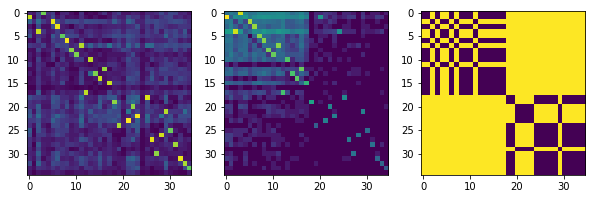

In [435]:
u.plot_grs(gr_scores, np.log(gr + 1), mask_graph)

In [391]:
mask_graph = np.ones_like(gr)
for e in negative_edges:
    mask_graph[e[0], e[1]] = 0
for e in positive_edges:
    mask_graph[e[0], e[1]] = 0
mask_graph -= np.diag(np.ones(35))

In [436]:
np.argsort(gr_scores * mask_graph)[:, ::-1][:,:5]

array([[30, 28, 31,  2,  5],
       [ 5, 21, 30, 29,  2],
       [ 0, 21, 18, 12,  8],
       [ 5, 23,  2, 27, 28],
       [33, 31, 29, 19, 27],
       [29,  0, 21,  8, 18],
       [21,  5,  2, 30, 22],
       [17, 25, 26, 21, 13],
       [20, 31,  2, 21, 33],
       [22,  5, 21,  2,  7],
       [21,  2, 29, 11,  7],
       [21, 30, 29, 22,  0],
       [29, 28,  7, 32, 22],
       [26, 23,  5, 11, 22],
       [26, 21, 32, 29, 22],
       [ 7, 29, 11, 31, 22],
       [ 2, 21, 27, 33, 23],
       [ 2, 22, 33, 11, 29],
       [11, 23, 22, 29, 17],
       [22, 15,  5, 21, 29],
       [18,  2, 11, 15,  8],
       [33, 13,  2, 17,  0],
       [28,  2, 25,  6,  0],
       [11, 25,  5, 18, 30],
       [ 2, 11, 23, 22, 29],
       [ 0, 23,  2, 29,  6],
       [ 0,  6, 23,  2,  3],
       [22, 11, 12, 29, 15],
       [ 2, 13,  6,  8,  9],
       [ 2, 19,  7,  6, 11],
       [ 2,  6, 15,  5, 13],
       [22,  6, 21, 15, 11],
       [ 2, 29, 15,  0, 22],
       [23, 29, 22, 15, 21],
       [22, 21

In [392]:
np.argmax(gr_scores * mask_graph)

737

In [394]:
737 // 35

21

In [395]:
737 % 35

2

In [368]:
gr_scores[32,33]

0.75

In [338]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [355]:
np.argsort(gr_scores[1])[::-1]

array([ 0, 22, 27,  2,  7, 31, 30, 11, 23, 33, 28,  5, 29, 21, 32, 20, 18,
       25, 34, 19,  6, 14, 10, 24, 26,  8,  4,  3, 17, 13, 12, 15, 16,  9,
        1])

In [356]:
gr_scores[1,20]

0.11

## TF EMBS

In [183]:
import tensorflow as tf
import keras

from keras.layers import Embedding, Dense

(195, 8)

In [449]:
VOC_SIZE = 35
EMB_SIZE = 20

In [450]:
tf.reset_default_graph()
sess = tf.Session()

In [451]:
inp = tf.placeholder(tf.int32, [None])

emb_layer = Embedding(VOC_SIZE, EMB_SIZE)
emb_val = emb_layer(inp)

dense_layer = Dense(VOC_SIZE)
out = dense_layer(emb_val)


In [452]:
target = tf.placeholder(tf.float32, [None, VOC_SIZE])

In [453]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=out))

In [454]:
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [455]:
sess.run(tf.global_variables_initializer())

In [456]:
def generate_batch(walks, batch_size, window):
    for i in range(len(walks) // batch_size):
        batch_walks = walks[i * batch_size:(i + 1) * batch_size]
        x = np.zeros(batch_size)
        y = np.zeros((batch_size, VOC_SIZE))
        
        for j, w in enumerate(batch_walks):
            pos = np.random.randint(0, len(w))
            x[j] = w[pos]
            for k in range(window):
                if k + pos + 1 < len(w):
                    y[j, w[k + pos + 1]] = 1
        
        
        yield x.astype(int) , y

In [446]:
def generate_batch(walks, batch_size, window):
    for i in range(len(walks) // batch_size):
        x = np.ones(10)
        y = np.zeros((10, VOC_SIZE))
        y[:,3] = 1
        
        
        yield x.astype(int) , y

In [447]:
x

(5, 7, 0)

In [457]:
for ep in range(1000):
    ep_loss = 0
    for x, y in generate_batch(walks, 20, 3):
        curr_loss = sess.run([train_step, loss], feed_dict={inp : x, target : y})
        ep_loss += curr_loss[1]
    
    print(ep_loss)

102.829320281744
55.55516944825649
43.82180081307888
41.48860560357571
40.694438859820366
39.48160842061043
38.078424870967865
36.7532964348793
35.86649268865585
34.830713510513306
34.10818015038967
34.25364647805691
33.406434282660484
32.41593873500824
32.572093456983566
32.27253770828247
31.834705144166946
31.67475888133049
31.750346548855305
31.490632116794586
30.963456958532333
31.3820708245039
30.619276247918606
30.596731424331665
30.408971905708313
30.044086031615734
30.677926547825336
30.69166788458824
30.809073247015476
30.885317377746105
30.579671196639538
30.343060210347176
30.621735006570816
30.3134046792984
29.823053419589996
30.392858311533928
30.042697079479694
29.90308140218258
29.982372149825096
30.023119427263737
30.133633941411972
30.022570051252842
29.978671796619892
30.46056218445301
30.07523190230131
29.73524648696184
30.162015788257122
29.621989741921425
29.70803539454937
29.82572489231825
29.941090688109398


KeyboardInterrupt: 

In [458]:
my_embs = sess.run(emb_layer.weights)[0]

In [459]:
pca = PCA(10)
my_embs_pca = pca.fit_transform(my_embs)

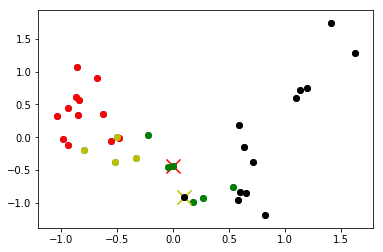

In [460]:
plot_embs_space(my_embs_pca, population_as_list, None)

# Clustering

In [437]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

In [ ]:
km = KMeans(2)

In [476]:
preds = km.fit_predict(emb[:,:])

In [477]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 3], dtype=int32)

In [472]:
sums = gr.sum(1).reshape(-1,1)
sums[sums == 0] = 1

In [473]:
preds = km.fit_predict(gr / sums)

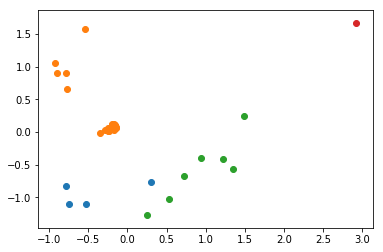

In [478]:
plt.scatter(emb[preds == 1,0], emb[preds == 1, 1])
plt.scatter(emb[preds == 0,0], emb[preds == 0, 1])
plt.scatter(emb[preds == 2,0], emb[preds == 2, 1])
plt.scatter(emb[preds == 3,0], emb[preds == 3, 1])

In [465]:
gm = GaussianMixture(4)

In [466]:
gm.fit(emb[:])
preds = gm.predict(emb[:])

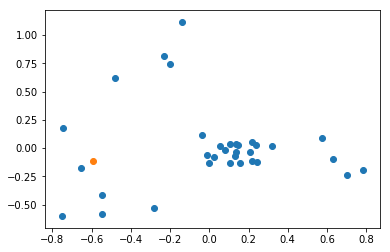

In [136]:
plt.scatter(log_emb[preds == 1,0], log_emb[preds == 1, 1])
plt.scatter(log_emb[preds == 0,0], log_emb[preds == 0, 1])

In [53]:
walks

[[0, 3, 6, 15, 8, 9, 10, 13, 14, 15],
 [1, 0, 3, 6, 8, 9, 10, 13, 4, 2],
 [2, 5, 7, 10, 9, 10, 13, 14, 15, 17],
 [3, 6, 8, 9, 10, 13, 14, 15, 17, 12],
 [4, 0, 3, 6, 8, 9, 7, 11, 16, 8],
 [5, 7, 11, 14, 15, 17, 12, 16, 10, 13],
 [6, 1, 0, 3, 6, 8, 9, 10, 11, 2],
 [7, 1, 0, 3, 6, 8, 9, 10, 13, 14],
 [8, 9, 6, 8, 9, 10, 16, 8, 9, 10],
 [9, 10, 13, 14, 15, 17, 21, 29, 8, 9],
 [10, 13, 14, 15, 3, 6, 8, 9, 6, 8],
 [11, 12, 16, 8, 9, 10, 4, 2, 12, 16],
 [12, 7, 11, 12, 16, 3, 14, 15, 7, 11],
 [13, 14, 15, 17, 12, 16, 6, 8, 9, 3],
 [14, 15, 17, 25, 30, 0, 3, 6, 8, 15],
 [15, 17, 12, 16, 3, 6, 1, 0, 3, 6],
 [16, 10, 13, 14, 15, 17, 12, 16, 10, 8],
 [17, 12, 16, 9, 10, 13, 1, 0, 3, 6],
 [18, 25, 1, 0, 3, 6, 8, 9, 17, 12],
 [19, 18, 25, 7, 11, 2, 5, 7, 11, 0],
 [20, 3, 6, 8, 10, 10, 13, 14, 15, 17],
 [21, 29, 8, 0, 3, 6, 8, 9, 12, 16],
 [22, 23, 21, 29, 8, 9, 10, 13, 14, 15],
 [23, 21, 29, 8, 9, 7, 11, 14, 15, 3],
 [24, 19, 18, 25, 0, 3, 6, 8, 9, 10],
 [25, 30, 27, 26, 16, 9, 12, 16, 0, 3],
 [26,

In [66]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [1, 20, 22, 23, 21, 29]]

In [88]:
model.most_similar(positive='1')

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('8', 0.603278398513794),
 ('3', 0.5847119688987732),
 ('30', 0.4833739399909973),
 ('6', 0.4828222692012787),
 ('22', 0.437547504901886),
 ('9', 0.4323849678039551),
 ('0', 0.3893508315086365),
 ('19', 0.3823843002319336),
 ('4', 0.3571333885192871),
 ('25', 0.3315662741661072)]

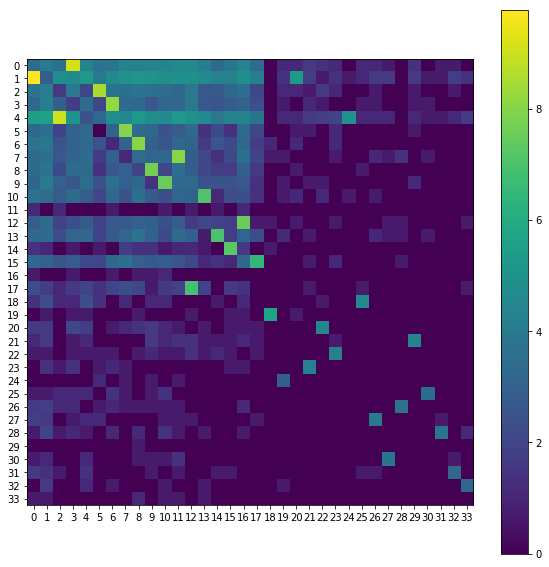

In [143]:
u.plot_gr(gr, log =1, all_ticks=1)

In [117]:
walks

[[17, 12, 16, 9, 10, 1, 0, 4, 2, 5, 0, 3, 6],
 [55],
 [58],
 [19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [6, 8, 8, 9, 3, 6, 8, 9, 10, 13, 14, 15, 17],
 [43],
 [4, 2, 5, 12, 16, 10, 8, 9, 10, 13, 14, 15, 17],
 [50],
 [65],
 [51],
 [62],
 [0, 9, 10, 1, 0, 3, 6, 8, 9, 10, 6, 8, 7],
 [9, 10, 13, 4, 2, 5, 7, 11, 2, 5, 7, 11, 16],
 [14, 15, 17, 12, 16, 6, 8, 9, 10, 13, 14, 15, 17],
 [15, 17, 12, 16, 6, 12, 16, 0, 3, 13, 14, 15, 6],
 [2, 5, 7, 11, 6, 8, 9, 10, 13, 14, 15, 17, 12],
 [61],
 [31, 0, 3, 6, 8, 9, 10, 13, 1, 0, 10, 13, 14],
 [66],
 [67],
 [8, 9, 10, 13, 4, 2, 5, 7, 11, 2, 5, 7, 11],
 [39],
 [71],
 [41],
 [20, 10, 13, 14, 15, 17, 4, 2, 5, 7, 11, 2, 5],
 [49],
 [37],
 [5, 7, 11, 2, 5, 7, 11, 16, 8, 9, 10, 13, 9],
 [40],
 [63],
 [13, 14, 15, 0, 3, 6, 8, 9, 10, 11, 16, 0, 3],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [22, 23, 21, 16, 9, 10, 3, 6, 8, 9, 10, 13, 14],
 [64],
 [38],
 [32, 33, 34],
 [42],
 [57],
 [27, 26, 28, 31, 1, 0, 3, 6, 8, 9, 10, 13, 14],
 [60],
 [54],
 [69]